<a href="https://colab.research.google.com/github/nnajeh/Segmentation/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import libraries


In [236]:
import os
!pip install -q torch_snippets pytorch_model_summary
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#@title Define dataset


In [ ]:
# Download datset
if not os.path.exists('dataset1'):
  !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip -q dataset1.zip
  !rm dataset1.zip


In [237]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                           ])

In [238]:
class SegData(Dataset):
  def __init__(self, split):
    self.items=stems(f'dataset1/images_prepped_{split}')
    self.split = split
  
  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    image = read(f'dataset1/images_prepped_{self.split}/{self.items[idx]}.png', 1)
    image = cv2.resize(image, (224,224))

    mask  = read(f'dataset1/annotations_prepped_{self.split}/{self.items[idx]}.png')
    mask = cv2.resize(mask, (224,224))
    
    return image, mask
 
  #selecting a random image index
  def choose(self):
    return self[randint(len(self))]
  
  #perform preprocessing on a batch of images:
  def collate_fn(self, batch):
    ims, masks = list(zip(*batch))
    ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
    return ims, ce_masks


In [239]:
# Define the training and validation datasets, as well as the dataloaders
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

2021-09-12 15:39:17.794 | INFO     | torch_snippets.paths:inner:24 - 367 files found at dataset1/images_prepped_train
2021-09-12 15:39:17.808 | INFO     | torch_snippets.paths:inner:24 - 101 files found at dataset1/images_prepped_test


In [240]:
#@title Define the U-NET Model


In [241]:
# Define the convolution block
def conv(in_channels, out_channels):
  return nn.Sequential(nn.Conv2d(in_channels, 
                                 out_channels,  
                                 kernel_size=3, 
                                 stride=1,   
                                 padding=1 ),
                       
                       nn.BatchNorm2d(out_channels),
                       nn.ReLU(inplace=True)
  )

In [242]:
# Define the up_conv block:
#ConvTranspose2d upscale the images, which reduce the dimensions of the image:
# from an image of in_channels number of channels to an image of out_channels number of channels

def up_conv(in_channels, out_channels):
  return nn.Sequential(nn.ConvTranspose2d(in_channels, 
                                          out_channels,
                                          kernel_size=2, 
                                          stride=2),
                      nn.ReLU(inplace=True)
  )

In [243]:
#Define the network class (UNet):

# import vgg16_bn pretrained model
from torchvision.models import vgg16_bn

class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()

    self.encoder = vgg16_bn(pretrained=pretrained).features

    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])
    self.bottleneck = nn.Sequential(*self.encoder[34:])

    self.conv_bottleneck = conv(512, 1024)
   
    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
   
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
   
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
   
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
   
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
   
    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)


  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)
    
    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)
    
    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)
    
    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)
    
    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)
    
    x = self.conv11(x)
    
    return x

In [244]:
#@title Train the model


In [245]:
#Define Loss Function
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  acc = (torch.max(preds, 1)[1] == targets).float().mean()
  return ce_loss, acc

In [246]:
#Define train function
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, ce_masks = data
  _masks = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()
  
  return loss.item(), acc.item()

In [247]:
def validate_batch(model, data, criterion):
  model.eval()
  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks, masks)

  return loss.item(), acc.item()

In [248]:
# define parameters
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [249]:
# train the model 
log = Report(n_epochs)

for ex in range(n_epochs):
  N = len(trn_dl)
  for i, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(ex+(i+1)/N,trn_loss=loss,trn_acc=acc, end='\r')

  N = len(val_dl)
  for i, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(i+1)/N,val_loss=loss,val_acc=acc, end='\r')
  
  log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.142	trn_acc: 0.750	val_loss: 0.772	val_acc: 0.823	(46.86s - 890.42s remaining)
EPOCH: 2.000	trn_loss: 0.676	trn_acc: 0.829	val_loss: 0.588	val_acc: 0.853	(94.04s - 846.36s remaining)
EPOCH: 3.000	trn_loss: 0.559	trn_acc: 0.850	val_loss: 0.588	val_acc: 0.838	(141.29s - 800.64s remaining)
EPOCH: 4.000	trn_loss: 0.505	trn_acc: 0.863	val_loss: 0.530	val_acc: 0.862	(188.47s - 753.87s remaining)
EPOCH: 5.000	trn_loss: 0.470	trn_acc: 0.870	val_loss: 0.457	val_acc: 0.868	(235.58s - 706.74s remaining)
EPOCH: 6.000	trn_loss: 0.417	trn_acc: 0.884	val_loss: 0.522	val_acc: 0.846	(282.63s - 659.46s remaining)
EPOCH: 7.000	trn_loss: 0.412	trn_acc: 0.883	val_loss: 0.493	val_acc: 0.858	(329.75s - 612.39s remaining)
EPOCH: 8.000	trn_loss: 0.370	trn_acc: 0.896	val_loss: 0.420	val_acc: 0.878	(376.79s - 565.19s remaining)
EPOCH: 9.000	trn_loss: 0.346	trn_acc: 0.903	val_loss: 0.414	val_acc: 0.878	(423.83s - 518.01s remaining)
EPOCH: 10.000	trn_loss: 0.320	trn_acc: 0.910	val_loss: 0.

100%|██████████| 121/121 [00:00<00:00, 804.22it/s]


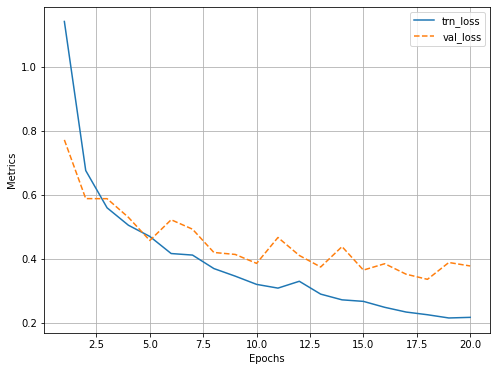

In [250]:
#Visualize the training, validation loss, and accuracy values
log.plot_epochs(['trn_loss','val_loss'])

In [251]:
# Calculate the predicted output on a new image

im, mask = next(iter(val_dl))  # im, mask  = next(iter(test_dataloader))
_mask = model(im)              # _mask = pretrained_G(pretrained_E(im))

In [252]:
_, _mask = torch.max(_mask, dim=1)

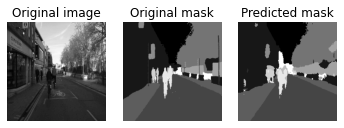

In [253]:
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], 
          mask.permute(1,2,0).detach().cpu()[:,:,0], 
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],
          nc=3, 
          titles=['Original image','Original mask', 'Predicted mask'])